In [1]:
# Scientific imports

%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# General imports

import csv, math, os, os.path, sys
import pandas as pd
import seaborn as sb
from sklearn import metrics
from IPython.display import display
sb.set()

In [2]:
# %load data-header-check.py
def dataAndHeaderCheck(f, log=False):
    """
    A function to make sure that all headers required for plotting a Light Curve
    are present, and alert the user if any are missing (and which ones).
    
    Input parameter (f) should be a path to a FITS file (local, cloud, etc)
    Input parameter (log) displays the printouts IFF set to True
    """
    
    # Flags
    allStellar = True
    allFitPara = True
    allFitData = True
    
    # List of needed headers
    stellar_params = ['TEFF', 'LOGG', 'TESSMAG']
    
    fit_params = ['TPERIOD', 'TDUR', 'TEPOCH', 'TDEPTH']
    
    fit_data = ['TIME', 'PHASE', 'LC_INIT', 'MODEL_INIT']
    
    # FITS Headers
    fh0 = fits.getheader(f, ext=0)
    fh1 = fits.getheader(f, ext=1)
    
    # FITS Columns
    fc = fits.getdata(f).columns
    
    # Loop through all headers and see if they are present using a Try/Except block
    if(log):
        print("Testing to see if all relevant information is present...")
    
    # First, the Stellar Parameters block
    for i in range (len(stellar_params)):
        try:
            fh0[stellar_params[i]]
        except:
            if(log):
                print("\tHeader {} not present!".format(stellar_params[i]))
            allStellar = False
    if(allStellar & log):
        print("\tAll Stellar Parameters present")
    
    # Next, the Fit Parameters block
    for i in range (len(fit_params)):
        try:
            fh1[fit_params[i]]
        except:
            if(log):
                print("\tFit Parameter {} not present!".format(fit_params[i]))
            allFitPara = False
    if(allFitPara & log):
        print("\tAll Fit Parameters present")
            
    # Lastly, the Fit Data block
    for i in range (len(fit_data)):
        try:
            fc[fit_data[i]]
        except:
            if(log):
                print("\tFit Data {} not present!".format(fit_data[i]))
            allFitData = False
    if(allFitData & log):
        print("\tAll Fit Data present")
        
    #allgood = (allStellar & allFitPara & allFitData)
    return (allStellar & allFitPara & allFitData)


In [3]:
fitsList = []
fits_directories = [x[0] for x in os.walk('.')]

for fits_root, fits_dirs, fits_files in os.walk('.'):
    for fits_file in fits_files:
        fullpath = os.path.join(fits_root, fits_file)
        if (os.path.splitext(fullpath.lower())[1]).endswith('.fits'):
            fitsList.append(fullpath)
print("Number of FITS files: {}".format(len(fitsList)))

Number of FITS files: 28


In [18]:
fits.getheader(fitsList[0], ext=0)

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-08-26'         / file creation date.                            
CREATOR = '793561 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.21 r60196' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [5]:
fits.getheader(fitsList[1])['TELESCOP']

'TESS'

This gives us the Telescope used for this particular mission. Let's loop through the whole list and see if it also gives us this for every entry (ie, it is a standard header)

In [6]:
for i in range(len(fitsList)):
    print(fits.getheader(fitsList[i])['TELESCOP'])

Kepler
TESS
IUE
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS
TESS


I discovered the `.endswith()` python string method, and this will be useful to me!

In [7]:
fits.getdata(fitsList[4], ext=0).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '143J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(11,13)'
    name = 'FLUX'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_ERR'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_BKG'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'FLUX_BKG_ERR'; format = '143E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(11,13)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
)

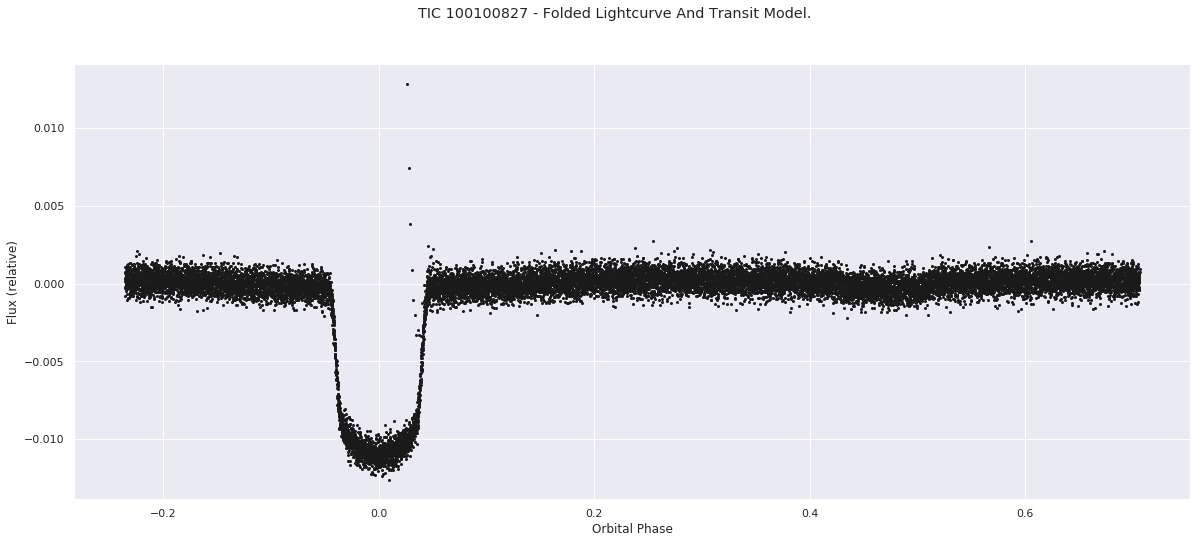

In [14]:
with fits.open(fitsList[1], mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and TESS magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['TESSMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    #####period = hdulist[1].header['TPERIOD']
    #####duration = hdulist[1].header['TDUR']
    #####epoch = hdulist[1].header['TEPOCH']
    #####depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    #####times = hdulist[1].data['TIME']
    phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    #####model_fluxes_init = hdulist[1].data['MODEL_INIT']
    
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
#####sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(20,8))

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(phases, fluxes_init, 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
#####ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Orbital Phase")

# Let's add some text in the top-right containing some of the fit parameters.
#plt.text(0.2, 0.012, "Period = {0:10.6f} days".format(period))
#plt.text(0.2, 0.010, "Duration = {0:10.6f} hours".format(duration))
#plt.text(0.2, 0.008, "Depth = {0:10.6f} ppm".format(depth))
#plt.text(0.45, 0.012, "Star Teff = {0:10.6f} K".format(star_teff))
#plt.text(0.45, 0.010, "Star log(g) = {0:10.6f}".format(star_logg))

plt.show()

In [9]:
#%reset

Okay, so the following things are _non-essential_:
- Period (we can calculate that algorithmically)
- Duration (this can also be calculated)
- Epoch (this is only ever given as a variable and not used to plot the LC)
- Depth (can be calculated)
- Times (never used)
- Model Fluxes (this is used to place a model LC, and that's what we're trying to do via ML)